In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # >= 0.9

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(style='ticks', context='poster', color_codes=True, rc={
    'figure.figsize': [10, 6],
    'legend.fontsize': 18,
    'lines.linewidth' : 5,
    'patch.linewidth': 2.2,
    'hatch.linewidth': 2,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5,
})

In [3]:
from dataloader import *
data = import_kaepora()
data = data[~data['z'].isna()]
data.head()

,v_siII,v_siII_err,z
kaepora,,,
2006td,10812.60,300.000,0.015880
1996z,12142.10,233.568,0.007575
1996x,11173.10,222.453,0.006945
1996c,10689.10,222.453,0.027000
2005m,8093.94,231.052,0.022000


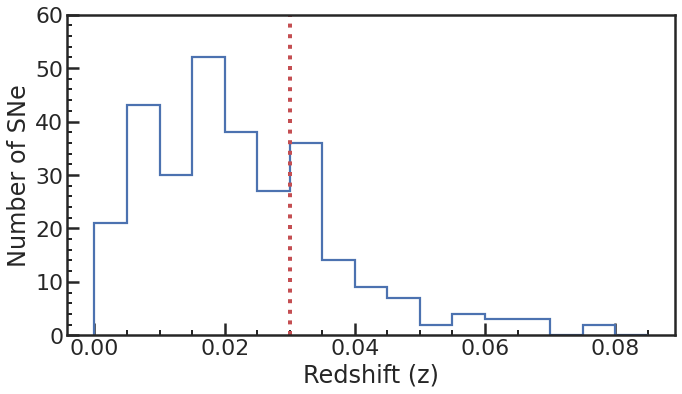

In [4]:
z_cutoff = 0.03

bins = np.arange(0, 9, 0.5) / 100
plt.hist(data['z'], bins=bins, histtype='step')
plt.vlines(z_cutoff, 0, 60, color='r', linestyle='dotted', linewidth=4)

plt.ylim(0, 60)
plt.xlabel('Redshift (z)')
plt.ylabel('Number of SNe')

plt.tight_layout()
plt.savefig('results/z_histogram.eps', orientation='landscape', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


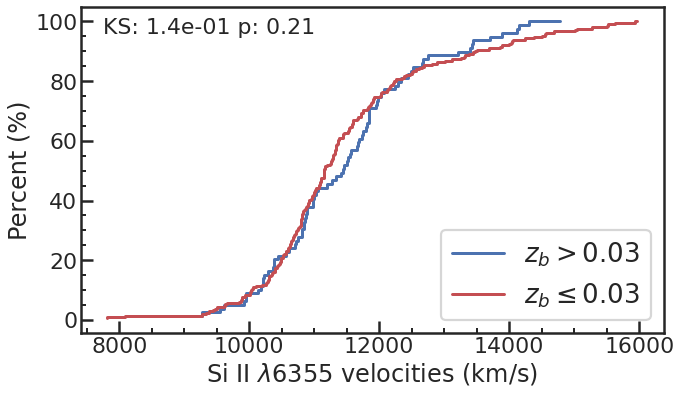

In [5]:
from scipy import stats
z_cutoff = 0.03
ks = stats.ks_2samp(data['v_siII'][data['z'] > z_cutoff], data['v_siII'][data['z'] <= z_cutoff])
bins = np.arange(7000, 16001, 500)

x = data['v_siII'][data['z'] > z_cutoff]
plt.plot(np.sort(x), np.arange(1, len(x) + 1) / len(x) * 100, linewidth=3, drawstyle='steps', label=f'$z_b > {z_cutoff:.2g}$')

x = data['v_siII'][data['z'] <= z_cutoff]
plt.plot(np.sort(x), np.arange(1, len(x) + 1) / len(x) * 100, linewidth=3, color='r', drawstyle='steps', label=f'$z_b \leq {z_cutoff:.2g}$')

plt.xlabel('Si II $\lambda$6355 velocities (km/s)')
plt.ylabel("Percent (%)")
plt.title(f'KS: {ks[0]:.1e} p: {ks[1]:.2f}', x=0.22, y=0.9, fontsize=22)
plt.legend(loc='lower right', fontsize=26)

plt.tight_layout()
plt.savefig('results/z_03_ks_test.eps', orientation='landscape', format='eps')

Text(0, 0.5, 'Number of SNe')

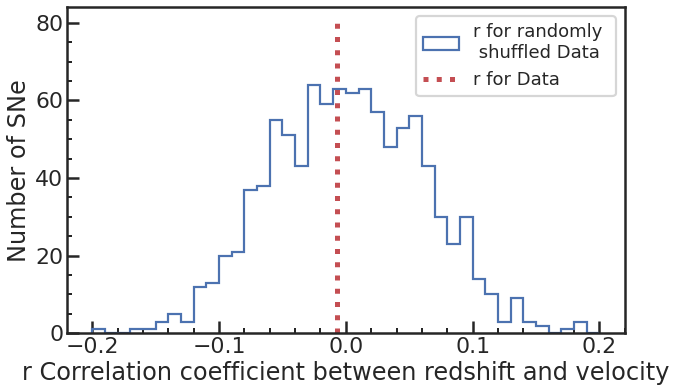

In [81]:
def get_correlation(data, column_a, column_b):
    return data.corr().loc[column_a, column_b]
    

def simulate(data, rep=1000):
    
    def make_sample(size=1000):
        shuffle_idx = np.random.randint(0, len(data), size=len(data))
        sample = pd.DataFrame.copy(data)
        sample['z'] = sample['z'].values[shuffle_idx]
        return sample
    
    results = []
    for i in range(rep):
        sample = make_sample()
        statistics = get_correlation(sample, 'v_siII', 'z')
        results.append(statistics)
        
    return results

results = simulate(data[['v_siII', 'z']])
plt.hist(results, bins=np.arange(-.20, .20+.01, .01), histtype='step', label='r for randomly \n shuffled Data');
plt.vlines(get_correlation(data, 'v_siII', 'z'), 0, 80, color='r', linestyle='dotted', label='r for Data')
plt.xlabel('r Correlation coefficient between redshift and velocity')
plt.legend()
plt.ylabel('Number of SNe')

In [80]:
np.sum(np.abs(get_correlation(data, 'v_siII', 'z')) <= np.abs(results)) / len(results)

0.9112

In [6]:
z_cutoffs = [0.01, 0.02, 0.03, 0.04]
bins = np.arange(7000, 16001, 500)

results = []
for z_cutoff in z_cutoffs:
    sample_greater = data['v_siII'][data['z'] > z_cutoff]
    sample_lesser = data['v_siII'][data['z'] <= z_cutoff]
    n = len(sample_greater)
    m = len(sample_lesser)
    alpha = 0.05
    D_level = 1/np.sqrt(n) * np.sqrt(-np.log(alpha/2) * (1 + n/m)/2)
    
    ks_test = stats.ks_2samp(sample_greater, sample_lesser)
    results.append({
        '$z_b$': z_cutoff,
        'ks': ks_test[0],
        'pvalue': ks_test[1],
        'size ($>z_b$)': len(sample_greater),
        'size ($\le z_b$)': len(sample_lesser),
        'D_level': D_level,
        'ks > D_level': ks_test[0] > D_level
    })
    
pd.DataFrame(results)

,$z_b$,ks,pvalue,size ($>z_b$),size ($\le z_b$),D_level,ks > D_level
0,0.01,0.125482,0.374987,227,64,0.192210,False
1,0.02,0.153912,0.054884,144,147,0.159235,False
2,0.03,0.136912,0.207019,79,212,0.179018,False
3,0.04,0.129502,0.706240,30,261,0.261817,False


Text(0.5, 62.499999999999915, 'Redshift (z)')

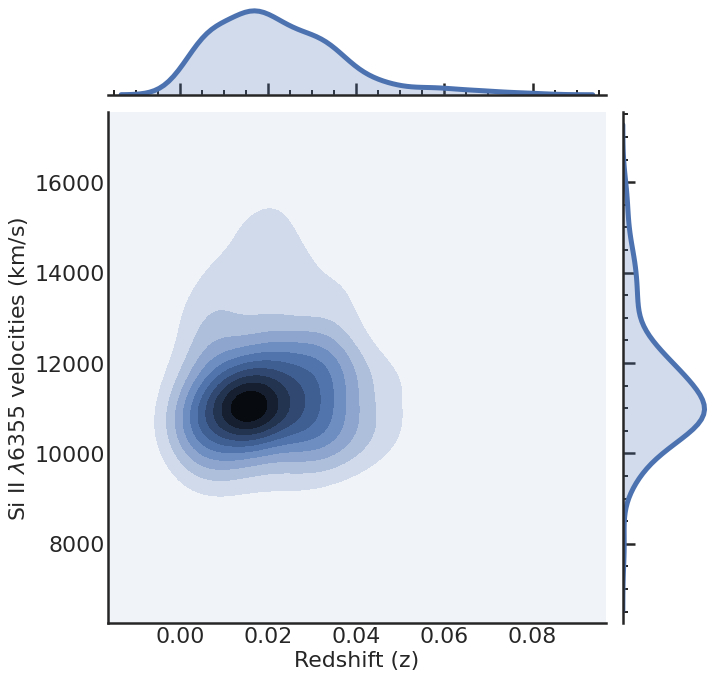

In [25]:
def standardize(x):
    return x
    return (x - np.mean(x)) / np.std(x)

p = sns.jointplot(standardize(data['z']), standardize(data['v_siII']), kind='kde', height=10)

# JointGrid has a convenience function
p.set_axis_labels('x', 'y', fontsize=16)

# or set labels via the axes objects
p.ax_joint.set_ylabel('Si II $\lambda$6355 velocities (km/s)', fontsize=22)
p.ax_joint.set_xlabel('Redshift (z)', fontsize=22)

Text(0, 0.5, 'count')

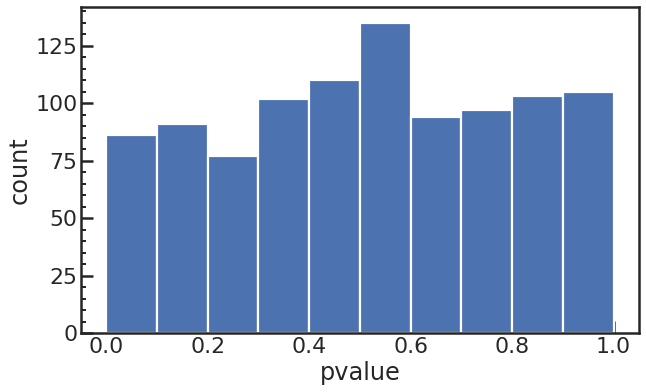

In [97]:
from scipy.stats import norm
cutoffs = np.arange(-2, 2+0.5, 1)
name = list(range(len(cutoffs)))

cutoffs = np.append(cutoffs, sample['z'].median())
name.append('median')

# p = sns.jointplot(standardize(sample['z']), standardize(sample['v']), kind='kde', height=6)

# # JointGrid has a convenience function
# p.set_axis_labels('x', 'y', fontsize=16)

# # or set labels via the axes objects
# p.ax_joint.set_ylabel('v', fontsize=22)
# p.ax_joint.set_xlabel('z', fontsize=22)

def simulate(size=300):
    sample = pd.DataFrame(
        [norm.rvs(size=size), norm.rvs(10000, 1000, size=size)],
        index=['z', 'v']
    ).T
    cutoff = np.median(sample['z'])
    sample_greater, sample_lesser = sample['v'][sample['z'] <= cutoff], sample['v'][sample['z'] > cutoff]
    ks_test = stats.ks_2samp(sample_greater, sample_lesser)
    return ks_test[1]


    
results = []
for i in range(1000):
    results.append(simulate(size=3000))
    
plt.hist(results)
plt.xlabel('pvalue')
plt.ylabel('count')